Comparing merge-tests between 3.6 revision f6459 and r6770

In [34]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import cmocean.cm as cm
import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [7]:
#load in the datas. Trying something new with dict objects...

#first run 
r1 = 'code';
runname1 = '/ocean/sallen/allen/research/MEOPAR/myResults/merge-tides-code/'
print (runname1)

#second run 
r2 = 'r6770'
runname2 = ('/ocean/sallen/allen/research/MEOPAR/myResults/merge-r6770/')
print (runname2)

runs = {r1: runname1, r2: runname2}


/ocean/sallen/allen/research/MEOPAR/myResults/merge-tides-code/
/ocean/sallen/allen/research/MEOPAR/myResults/merge-r6770/


In [9]:
fUs={}; fVs={}; fTs={}
for key, path in runs.items():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1d_20160820_20160928_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1d_20160820_20160928_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1d_20160820_20160928_grid_T.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1d_20160820_20160928_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1d_20160820_20160928_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1d_20160820_20160928_grid_T.nc','r');

Show info about the files

In [10]:
for key in runs:
    print (key)
    nc_tools.show_dataset_attrs(fUs[key])

r6770
file format: NETCDF4
name: SalishSea_1d_20160820_20160928
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-Dec-10 21:41:57 PST
history: Sun Dec 11 05:20:26 2016: ncks -4 -L4 -O SalishSea_1d_20160820_20160928_grid_U.nc SalishSea_1d_20160820_20160928_grid_U.nc
NCO: "4.5.2"
code
file format: NETCDF4
name: SalishSea_1d_20160820_20160928
description: ocean U grid variables
title: ocean U grid variables
Conventions: CF-1.5
production: An IPSL model
timeStamp: 2016-Dec-10 17:30:35 PST
history: Sun Dec 11 01:19:56 2016: ncks -4 -L4 -O SalishSea_1d_20160820_20160928_grid_U.nc SalishSea_1d_20160820_20160928_grid_U.nc
NCO: "4.5.2"


In [11]:
for key in runs:
    print (key)
    nc_tools.show_variable_attrs(fUs[key])

r6770
<class 'netCDF4._netCDF4.Variable'>
float32 area(y, x)
    standard_name: cell_area
    units: m2
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 bounds_lat(y, x, nvertex)
unlimited dimensions: 
current shape = (898, 398, 4)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 bounds_lon(y, x, nvertex)
unlimited dimensions: 
current shape = (898, 398, 4)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 depthu(depthu)
    long_name: Vertical U levels
    units: m
    axis: Z
    positive: down
    bounds: depthu_bounds
unlimited dimensions: 
current shape = (40,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 depthu_bounds(depthu, axis_nbounds)
unlimited dimensions: 
current shape = (40, 2)
filling on, defaul

Both have 40 days

In [12]:
#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig[r1] = datetime.datetime.strptime(
                    tim_count[r1].time_origin.title(), '%Y-%m-%d %H:%M:%S')
t_orig[r2] = datetime.datetime.strptime(
                tim_count[r2].time_origin.title(), '%Y-%m-%d %H:%M:%S')


### Comparison plots

Quick look at surface fields near the start and at end of run

In [16]:
def plot_variable(t,depthlevel,var, var_name,vmin=-0.5, vmax=0.5,
                  diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
        print (var_name, 'max', np.max(var[r1][t,:,:]-var[r2][t,:,:]), 
               'min', np.min(var[r1][t,:,:]-var[r2][t,:,:]))
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
        print (var_name, 'max', np.max(var[r1][t, depthlevel, :, :]-var[r2][t, depthlevel, :, :]), 
               'min', np.min(var[r1][t, depthlevel, :, :] - var[r2][t, depthlevel, :, :]))
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0
U [m/s] max 0.217601 min -0.146402
V [m/s] max 0.195636 min -0.172839
SSH [m] max 0.0174293 min -0.00631562
Sal [g/kg] max 3.36094 min -4.34398
Temp [deg C] max 1.52061 min -2.483


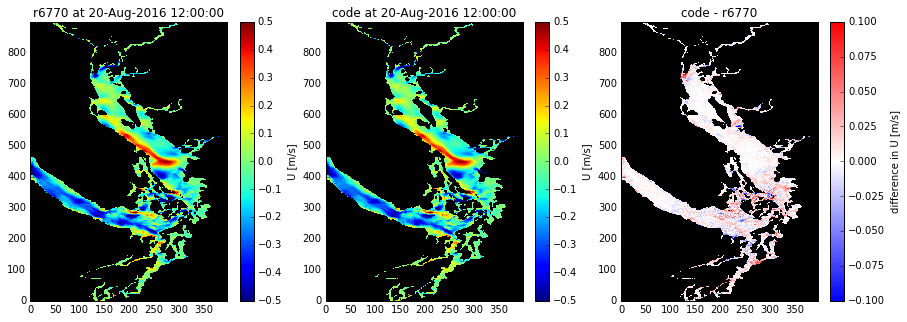

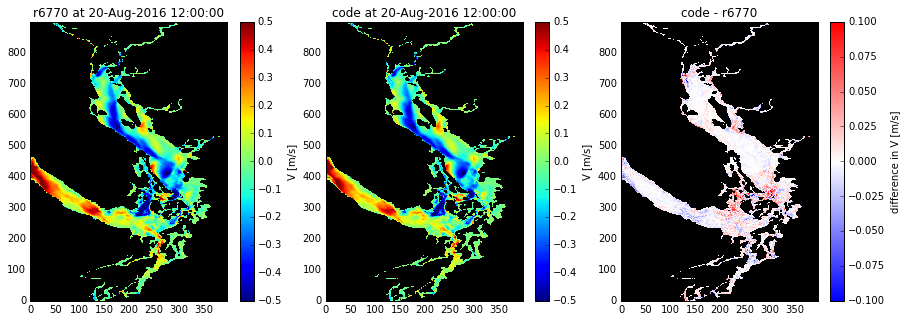

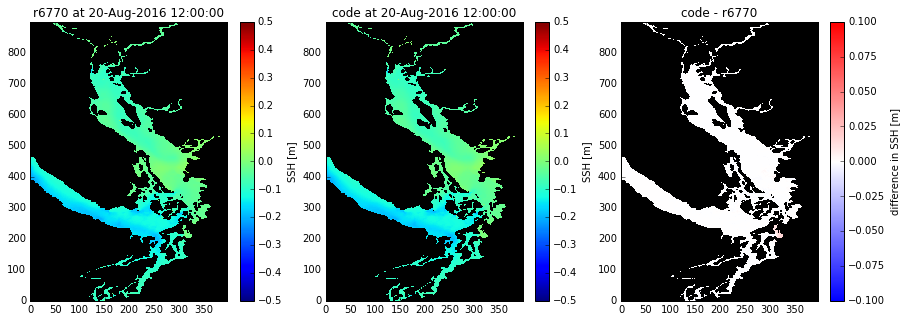

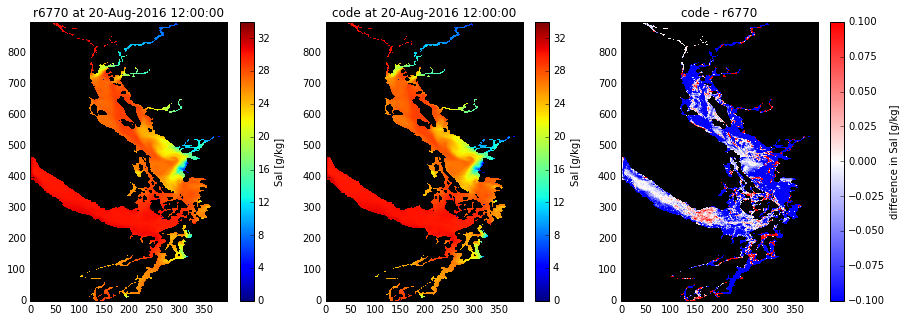

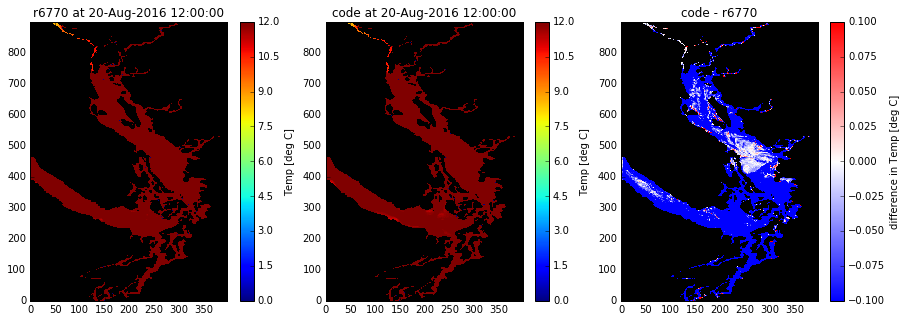

In [17]:
t=0
depthlevel=0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Even at this first day we see strong changes.  The new version is Saltier and warmer at the surface

Time = 39, depth level = 0
U [m/s] max 0.187575 min -0.192038
V [m/s] max 0.205687 min -0.198608
SSH [m] max 0.0154589 min -0.00860849
Sal [g/kg] max 3.36945 min -5.18009
Temp [deg C] max 2.2408 min -1.55472


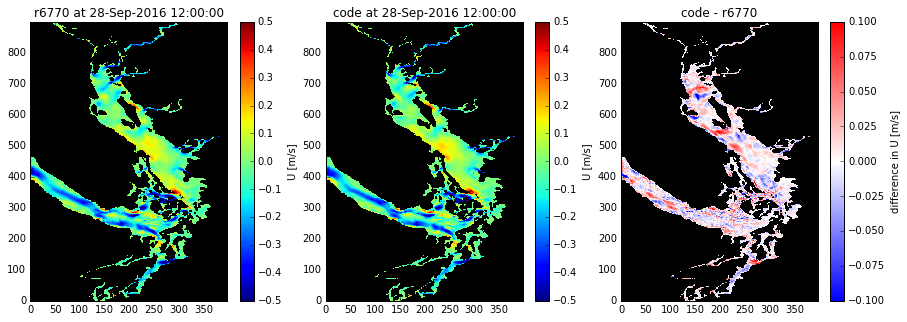

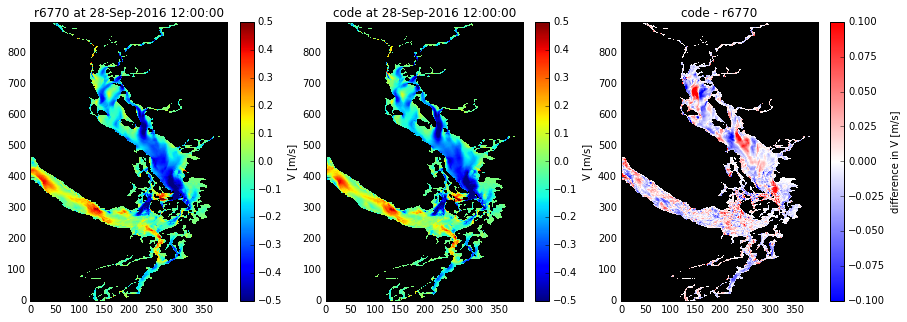

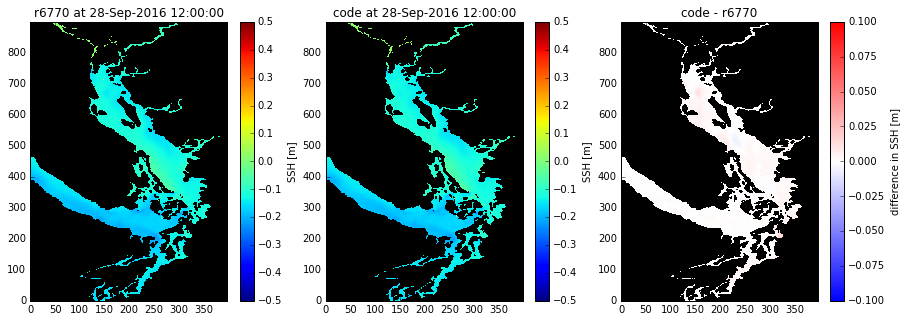

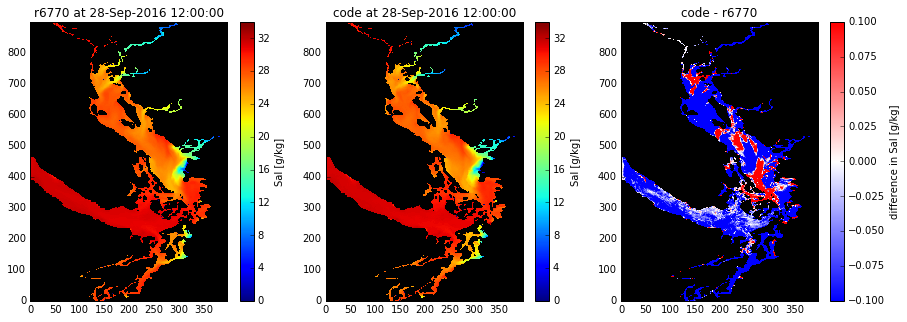

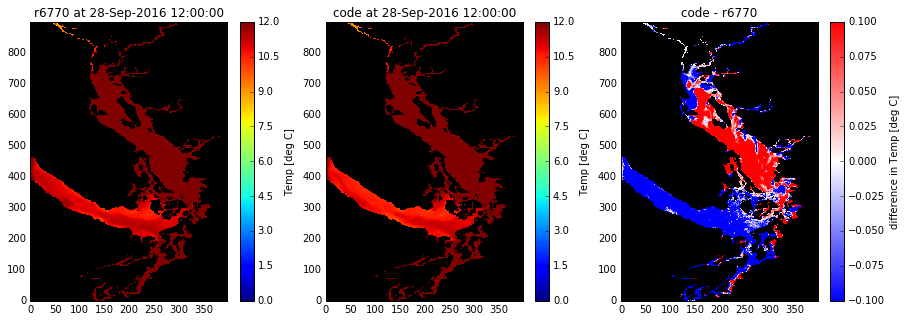

In [18]:
t = 39
depthlevel = 0

print ('Time = {}, depth level = {}'.format(t,depthlevel))
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [g/kg]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Now fresher and colder at surface

# Profiles

In [19]:
def compare_profile(var,var_name, i,j,t,zmin=0,zmax=400,vmin=0,vmax=34):
    """Function to compare a variable over depth at point i,j and time t.
    Plots each sim on the same axis and then their difference over depth"""

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    for key in runs:
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        ax.plot(var[key][t,:,j,i],Ds[key], '-o',label=key)
    ax.set_title(out.strftime('%d-%b-%Y %H:%M:%S'))
    ax.set_xlabel(var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.legend(loc=0)
    ax=axs[1]
    #difference    
    diff = var[r1][t,:,j,i]-var[r2][t,:,j,i]
    ax.plot(diff,Ds[key], '-ro')
    ax.set_title('Difference: ' +r1+' - ' +r2)
    ax.set_xlabel('Difference in ' + var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])

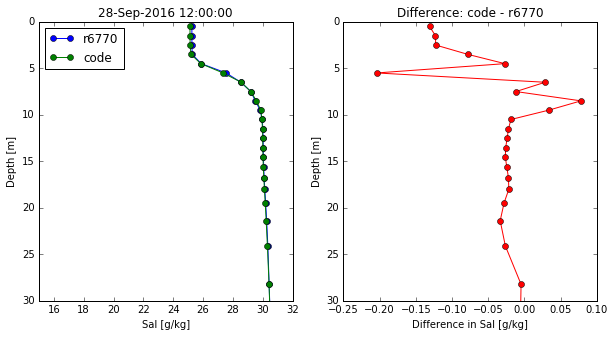

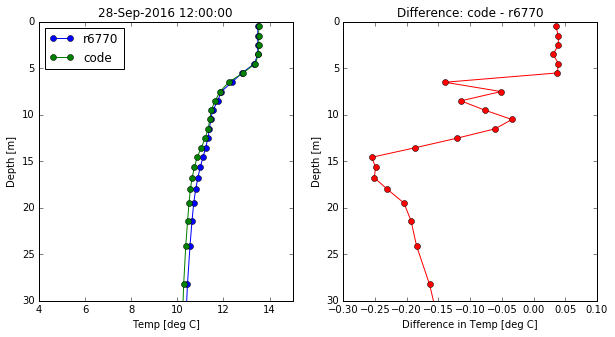

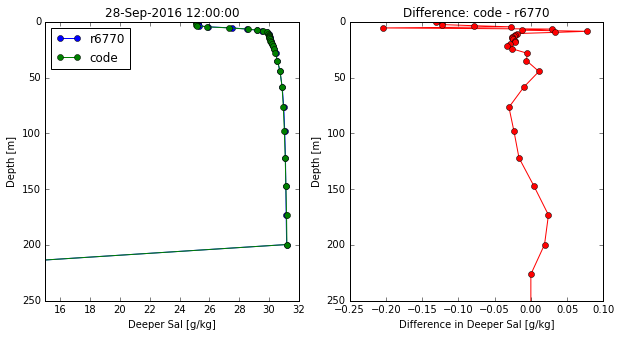

In [20]:
tp = t
ip = 300
jp = 450
zmax= 30
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=4,vmax=15)
zmax=250
compare_profile(Ss,'Deeper Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)


* Central SoG

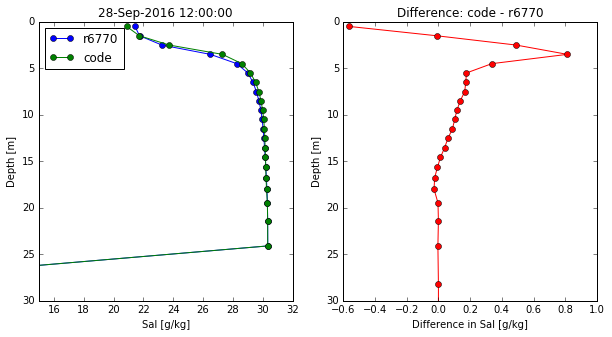

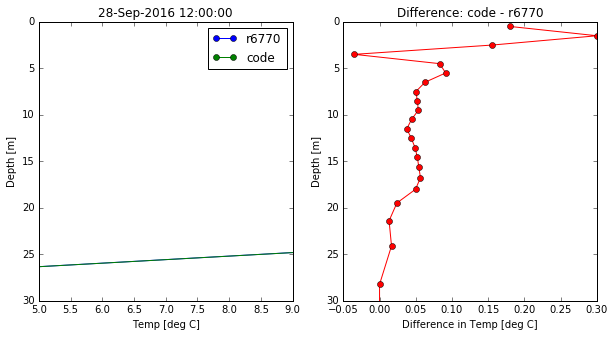

In [21]:
tp = t
ip = 300
jp = 400
zmax=30
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=9)


* Closer to Boundary Pass

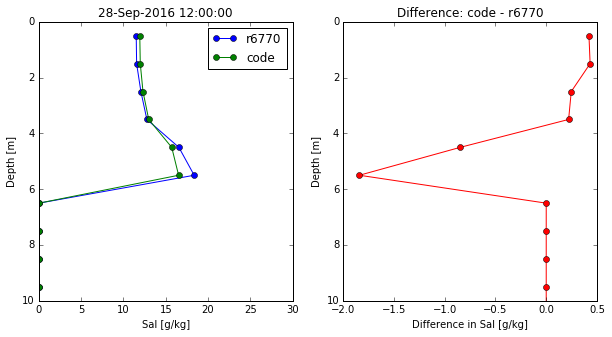

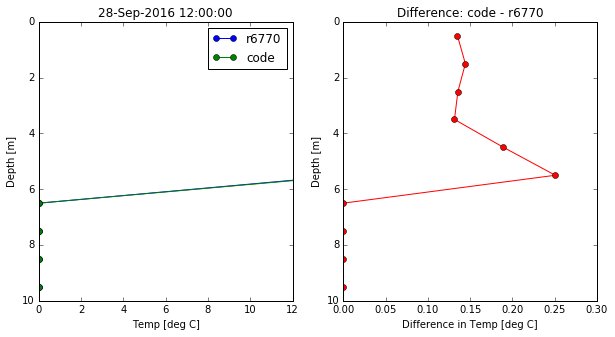

In [22]:
tp = t
ip = 310
jp = 430
zmax=10
compare_profile(Ss,'Sal [g/kg]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=30)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=0,vmax=12)

* r6770 is more mixed

## Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [23]:
def summarize_differences(var, var_name, imin=0, imax=396, jmin=0, jmax=896, ts=64):
    diff = var[r1][0:ts,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print (var_name)
    print ('min diff: {0:.3}, index {1}'.format(diff.min(),inds_min))
    print ('max diff: {0:.3}, index {1}'.format(diff.max(),inds_max))
    print ('mean diff {0:.3}'.format(diff.mean()))

In [24]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [g/kg]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key], key, ts=64)

Sal [psu]
min diff: -8.05, index (18, 0, 426, 260)
max diff: 11.6, index (31, 3, 441, 324)
mean diff -0.00256
V [m/s]
min diff: -0.4, index (25, 0, 329, 310)
max diff: 0.631, index (29, 0, 726, 182)
mean diff 3.19e-05
U [m/s]
min diff: -0.358, index (12, 0, 596, 235)
max diff: 0.533, index (29, 0, 730, 186)
mean diff 4.05e-05
Temp [deg C]
min diff: -3.62, index (27, 0, 691, 144)
max diff: 12.4, index (12, 3, 267, 356)
mean diff 0.0155
SSH [m]
min diff: -0.0313, index (23, 416, 336)
max diff: 0.0234, index (31, 210, 325)
mean diff 0.000331


* Lots of differences

### Boundary conditions on SSH

How do the ssh/u/v near the boundaries compare?

In [25]:
sshs={}
us={}
vs={}
i=1
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
        

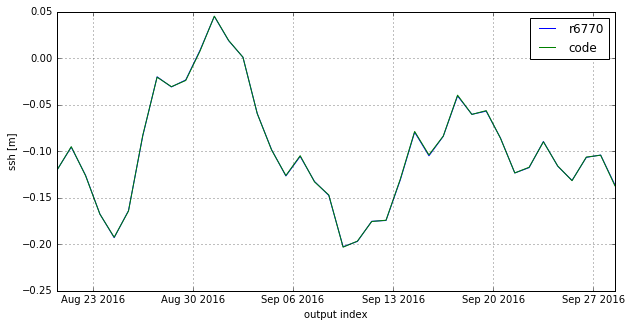

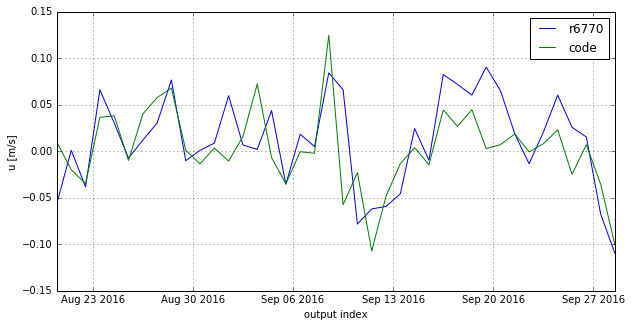

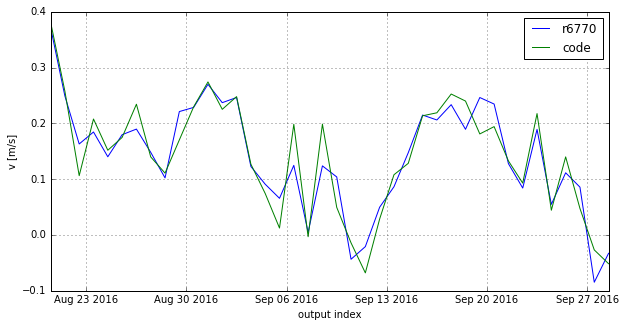

In [26]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()


Next to boundary

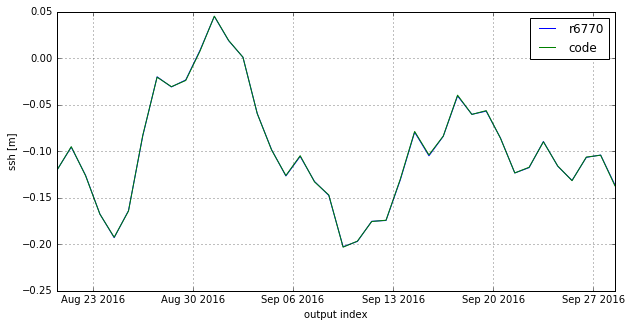

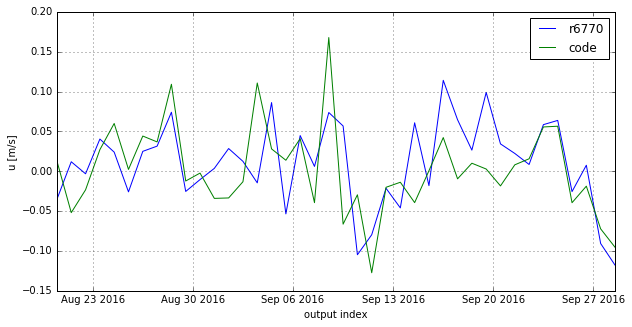

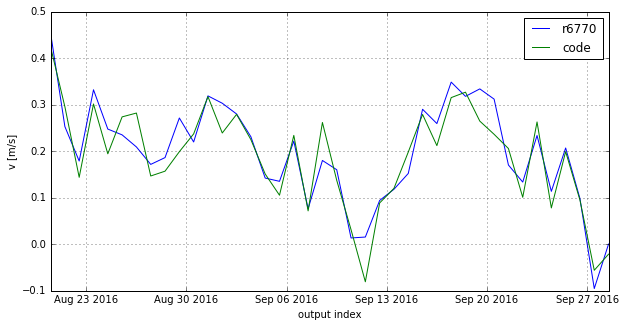

In [27]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

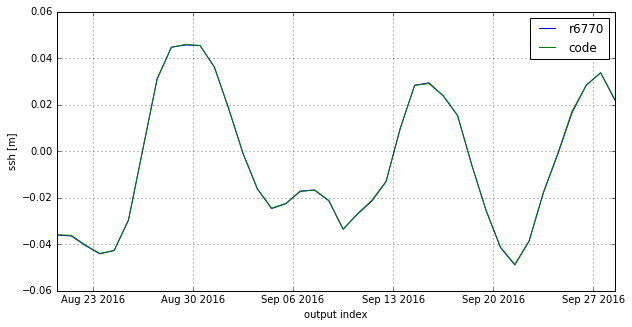

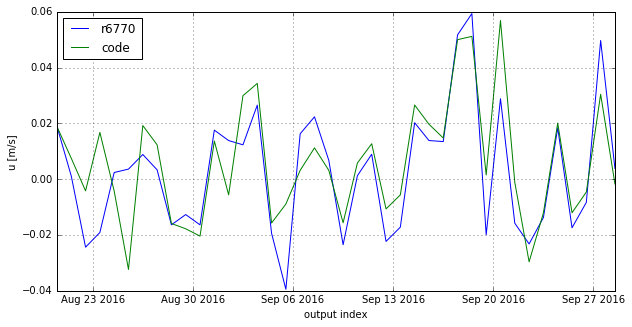

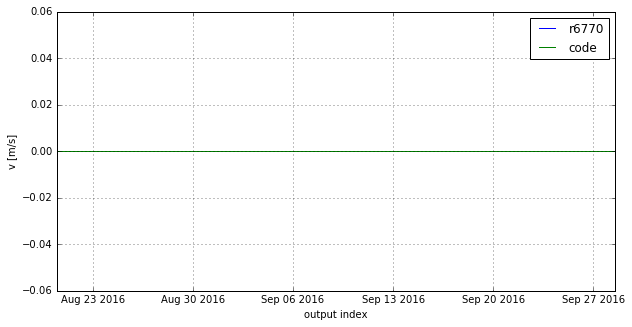

In [28]:
sshs={}
us={}
vs={}
i=50
j=896
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

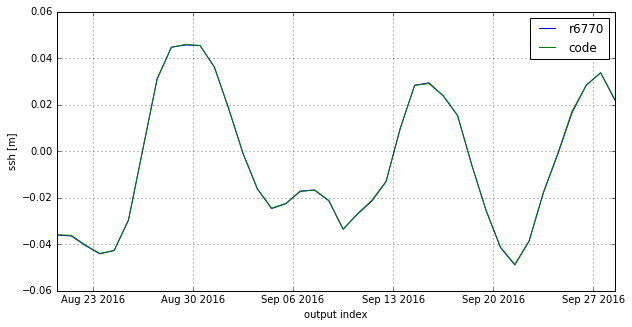

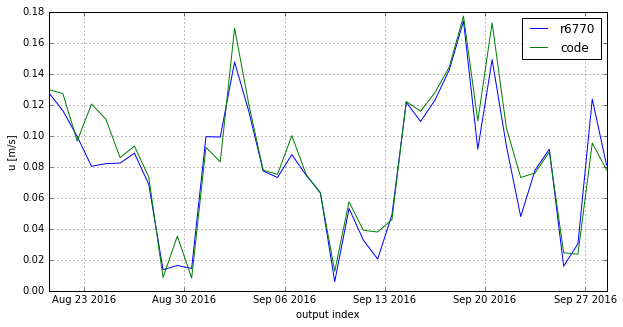

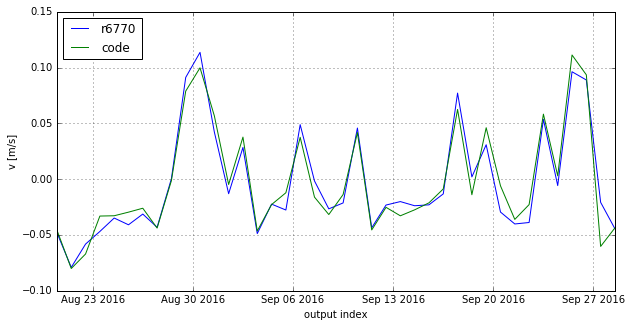

In [29]:
sshs={}
us={}
vs={}
i=50
j=895
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Differences but not systematic

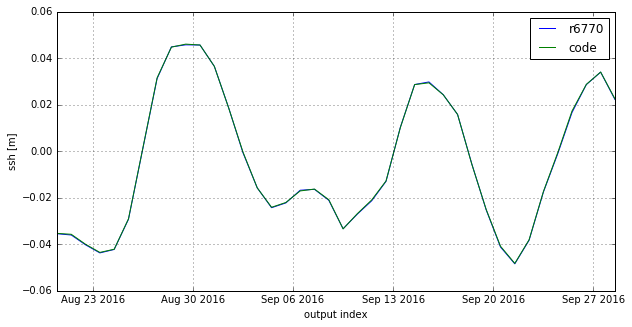

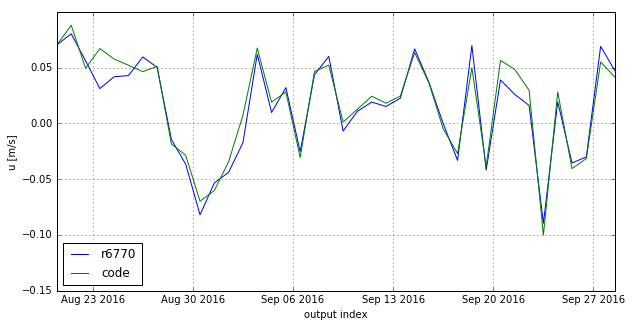

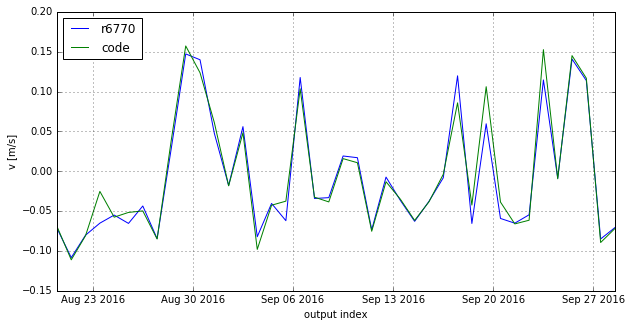

In [30]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

# Closer look at currents at JdFS boundary

Compare fields over depth and along the JdF boundary

In [43]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,
                     vmax=1,diffmin=-0.5,diffmax=0.5, cmap=cm.balance):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2], [r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap=cm.curl)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


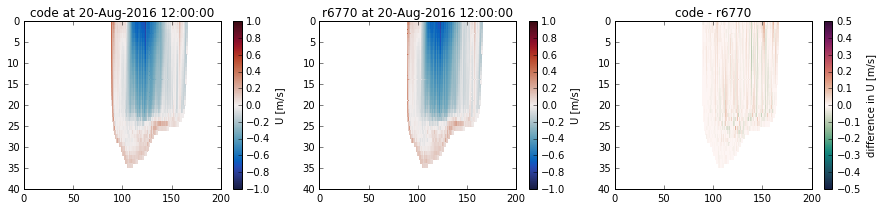

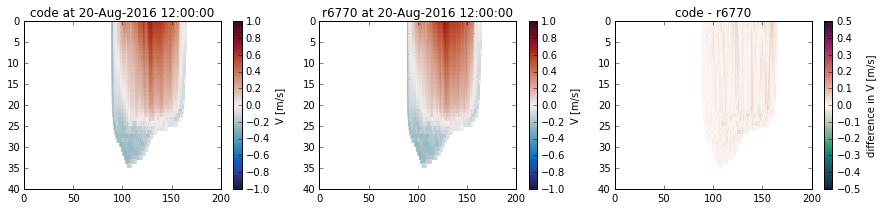

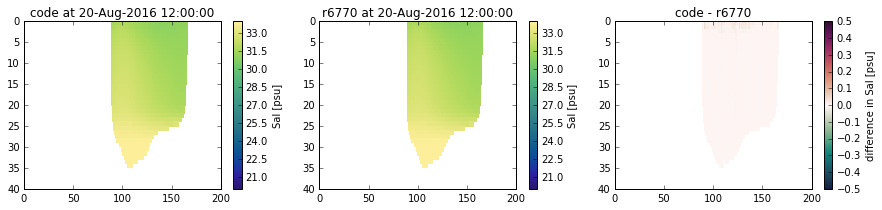

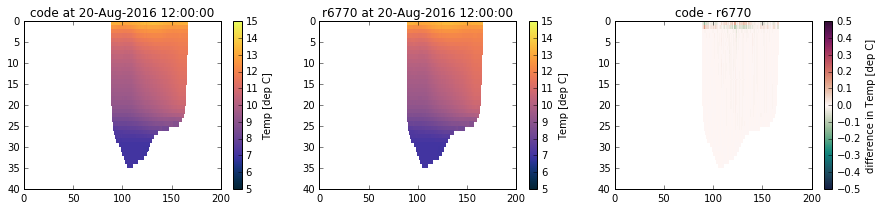

In [44]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t, vmin=20, vmax=34, cmap=cm.haline)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t, vmin=5, vmax=15, cmap=cm.thermal)

print ('Mouth of JdF at t = {}'.format(t))

Max difference time

Mouth of JdF at t = 29


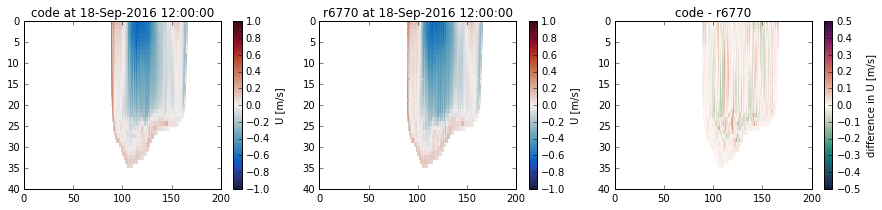

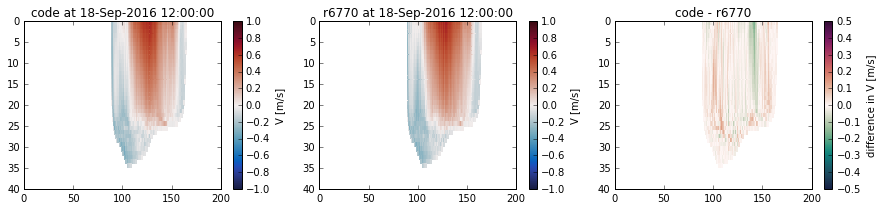

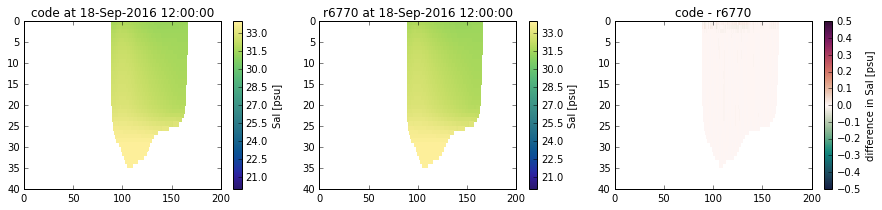

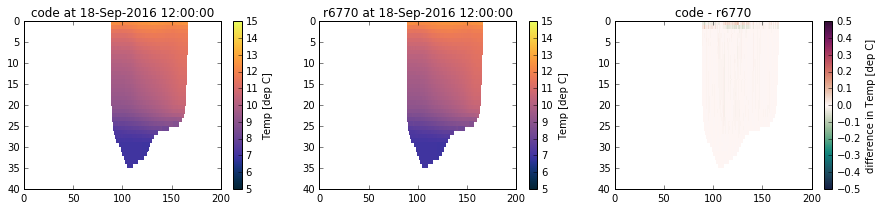

In [47]:
t = 29
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20, vmax=34, cmap=cm.haline)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5, vmax=15, cmap=cm.thermal)

print ('Mouth of JdF at t = {}'.format(t))

Last time

Mouth of JdF at t = 39


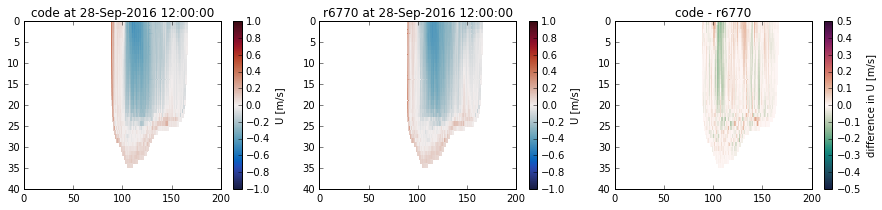

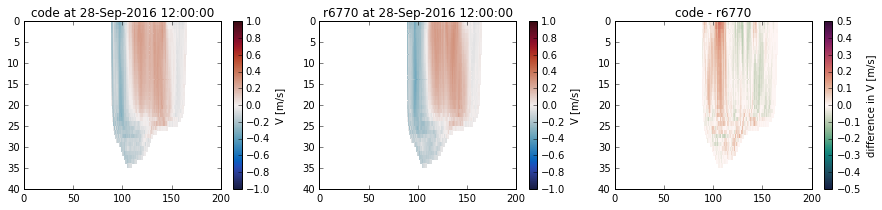

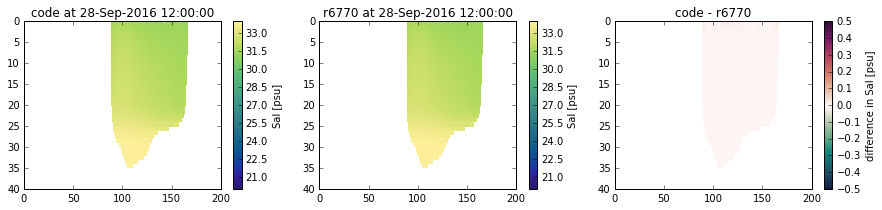

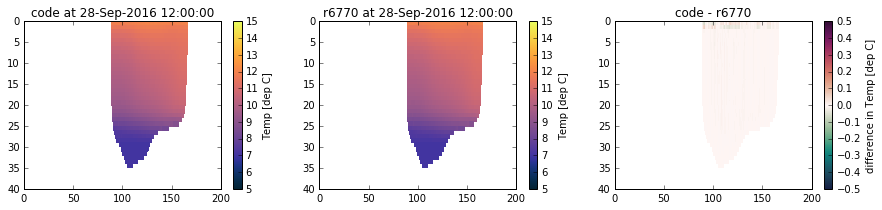

In [48]:
t=39
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20, vmax=34, cmap=cm.haline)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5, vmax=15, cmap=cm.thermal)

print ('Mouth of JdF at t = {}'.format(t))

## Thalwegs

In [49]:
from salishsea_tools import visualisations as vis

In [50]:
print (Ss[r1])
mesh_mask = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

<class 'netCDF4._netCDF4.Variable'>
float32 vosaline(time_counter, deptht, y, x)
    standard_name: sea_water_practical_salinity
    long_name: salinity
    units: 1e-3
    online_operation: average
    interval_operation: 30 s
    interval_write: 1 d
    cell_methods: time: mean (interval: 30 s)
    cell_measures: area: area
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered deptht nav_lon nav_lat
unlimited dimensions: time_counter
current shape = (40, 40, 898, 398)
filling on


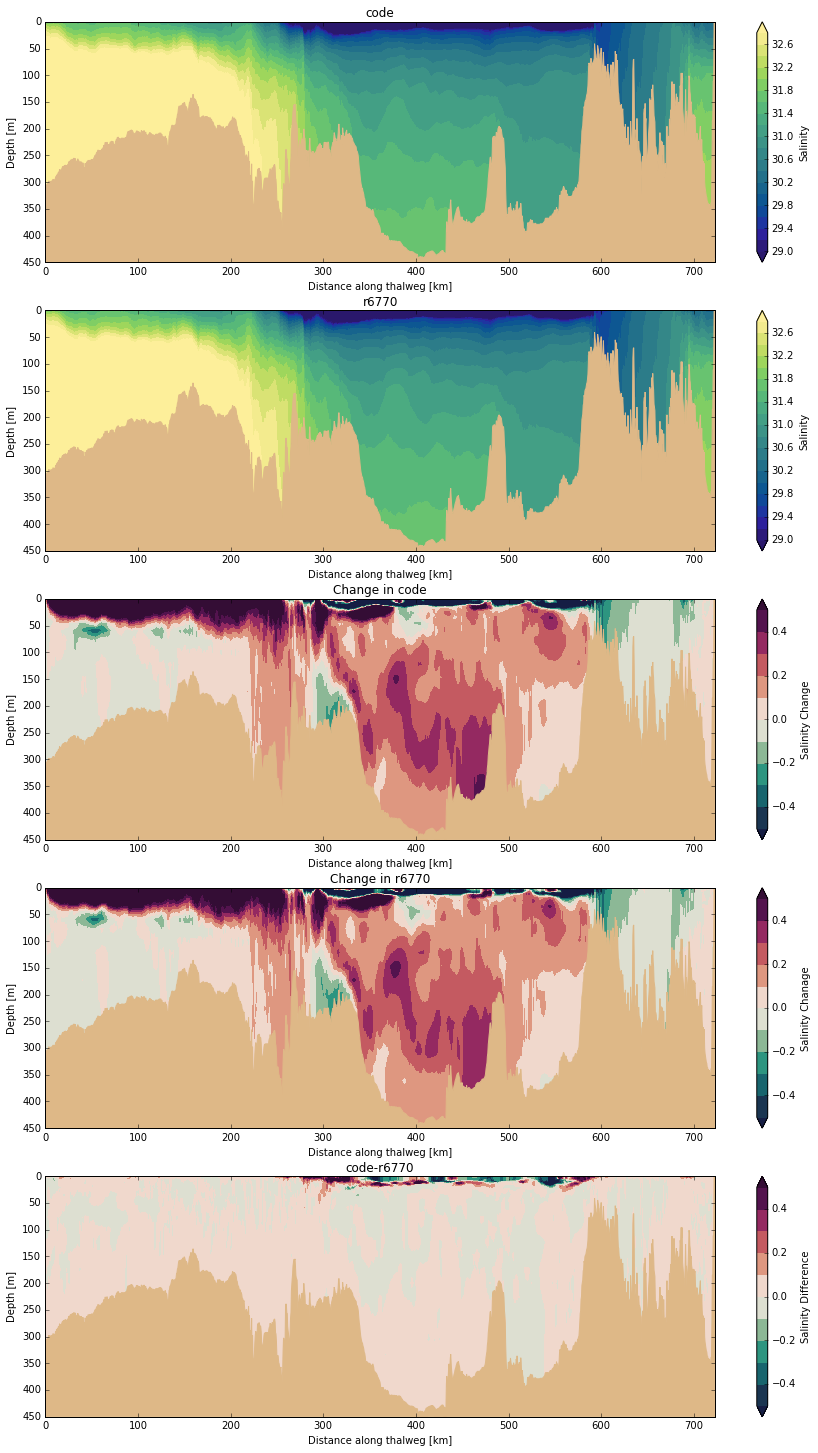

In [90]:
fig,ax = plt.subplots(5,1,figsize=(15,25))
clevels = np.arange(29., 33., 0.2)
ts = 39; t0 = 0

cbar = vis.contour_thalweg(ax[0], Ss[r1][ts], bathy, X, Y, mesh_mask, 'gdept_0', clevels, cmap=cm.haline)
ax[0].set_ylim([450,0])
cbar.set_label('Salinity')
ax[0].set_title(r1)

cbar = vis.contour_thalweg(ax[1], Ss[r2][ts], bathy, X, Y, mesh_mask, 'gdept_0', clevels, cmap=cm.haline)
ax[1].set_ylim([450,0])
cbar.set_label('Salinity')
ax[1].set_title(r2)

clevels = np.arange(-0.5, 0.6, 0.1)
cbar = vis.contour_thalweg(ax[2], Ss[r1][ts]-Ss[r1][0], bathy, X, Y, mesh_mask, 'gdept_0', clevels, 
                           cmap=cm.curl)
ax[2].set_ylim([450,0])
cbar.set_label('Salinity Change')
ax[2].set_title("Change in "+r1)

cbar = vis.contour_thalweg(ax[3], Ss[r2][ts]-Ss[r2][0], bathy, X, Y, mesh_mask, 'gdept_0', clevels, 
                           cmap=cm.curl)
ax[3].set_ylim([450,0])
cbar.set_label('Salinity Chanage')
ax[3].set_title("Change in "+r2)

cbar = vis.contour_thalweg(ax[4], Ss[r1][ts]-Ss[r2][ts], bathy, X, Y, mesh_mask, 'gdept_0', clevels, 
                           cmap=cm.curl)
ax[4].set_ylim([450,0])
cbar.set_label('Salinity Difference')
ax[4].set_title(r1+"-"+r2)

So r6770 causes the plume to spread more.

In [68]:
fCRs={}; fPAs={}; fVAs={}
CR ={}; PA={}; VA={}
stations = [VA, PA, CR]
for key, path in runs.items():
        fPAs[key] = NC.Dataset(path +'/PointAtkinson.nc','r');
        fCRs[key] = NC.Dataset(path +'/CampbellRiver.nc','r');
        fVAs[key] = NC.Dataset(path +'/Victoria.nc','r');
        for fs, station in zip([fPAs, fCRs, fVAs], stations):
            station[key] = fs[key].variables['sossheig'][:, 0, 0]

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


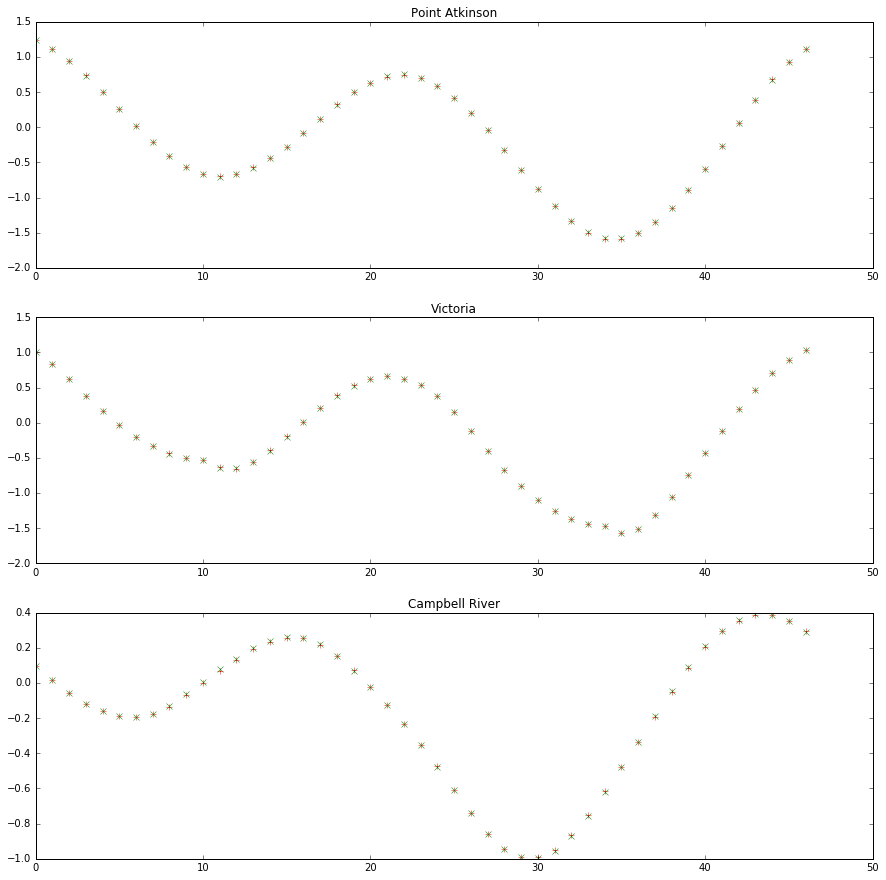

In [79]:
linetype = {r1: '+r', r2: 'xg'}
stationname = ['Point Atkinson','Victoria','Campbell River']
fig, axs = plt.subplots(3, 1, figsize=(15,15))
for station, ax, name in zip(stations, axs, stationname):
    for key in [r1, r2]:
        ax.plot(station[key][-1920/40:-1], linetype[key])
    ax.set_title(name)

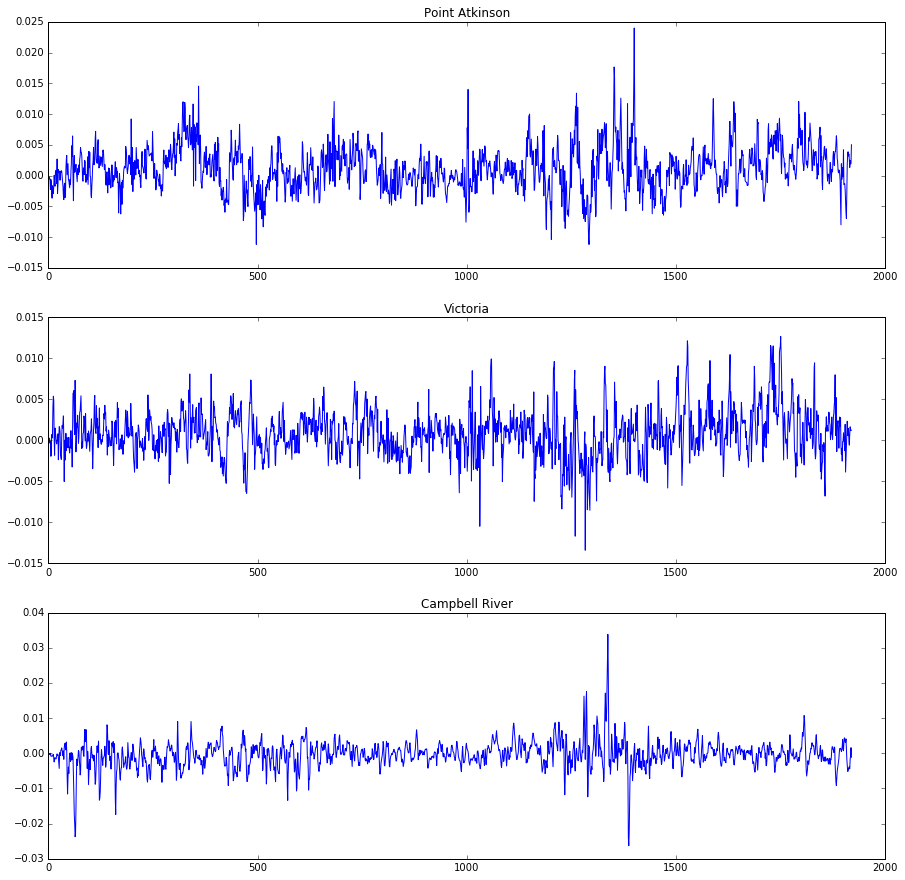

In [81]:
linetype = {r1: '+r', r2: 'xg'}
stationname = ['Point Atkinson','Victoria','Campbell River']
fig, axs = plt.subplots(3, 1, figsize=(15,15))
for station, ax, name in zip(stations, axs, stationname):
    ax.plot(station[r1]-station[r2])
    ax.set_title(name)

Changes are minor to the tides.  Differences are most random.